# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/medz1966/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 89 (delta 28), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 317.10 KiB | 5.20 MiB/s, done.
Resolving deltas: 100% (28/28), done.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


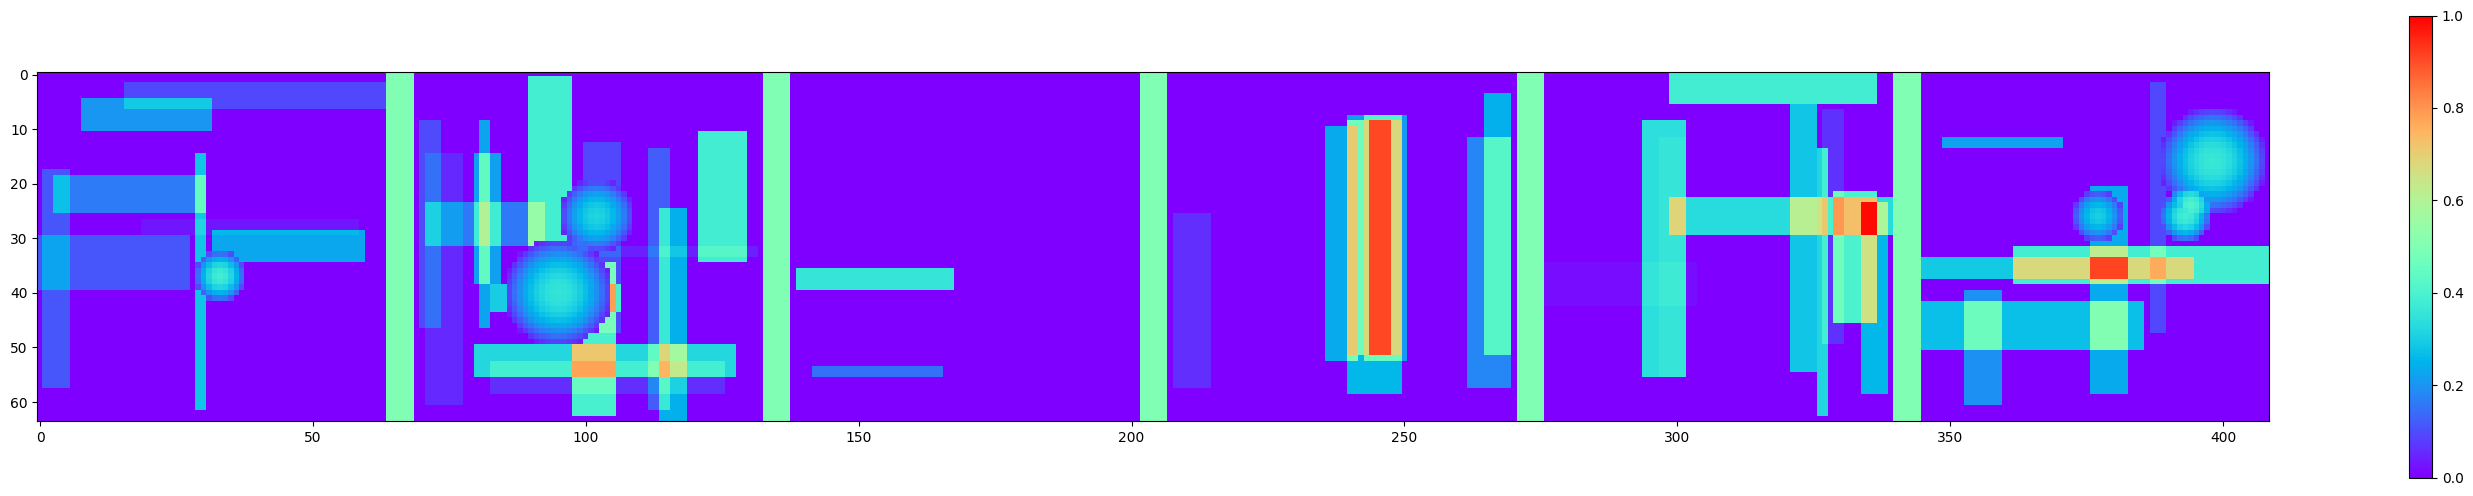

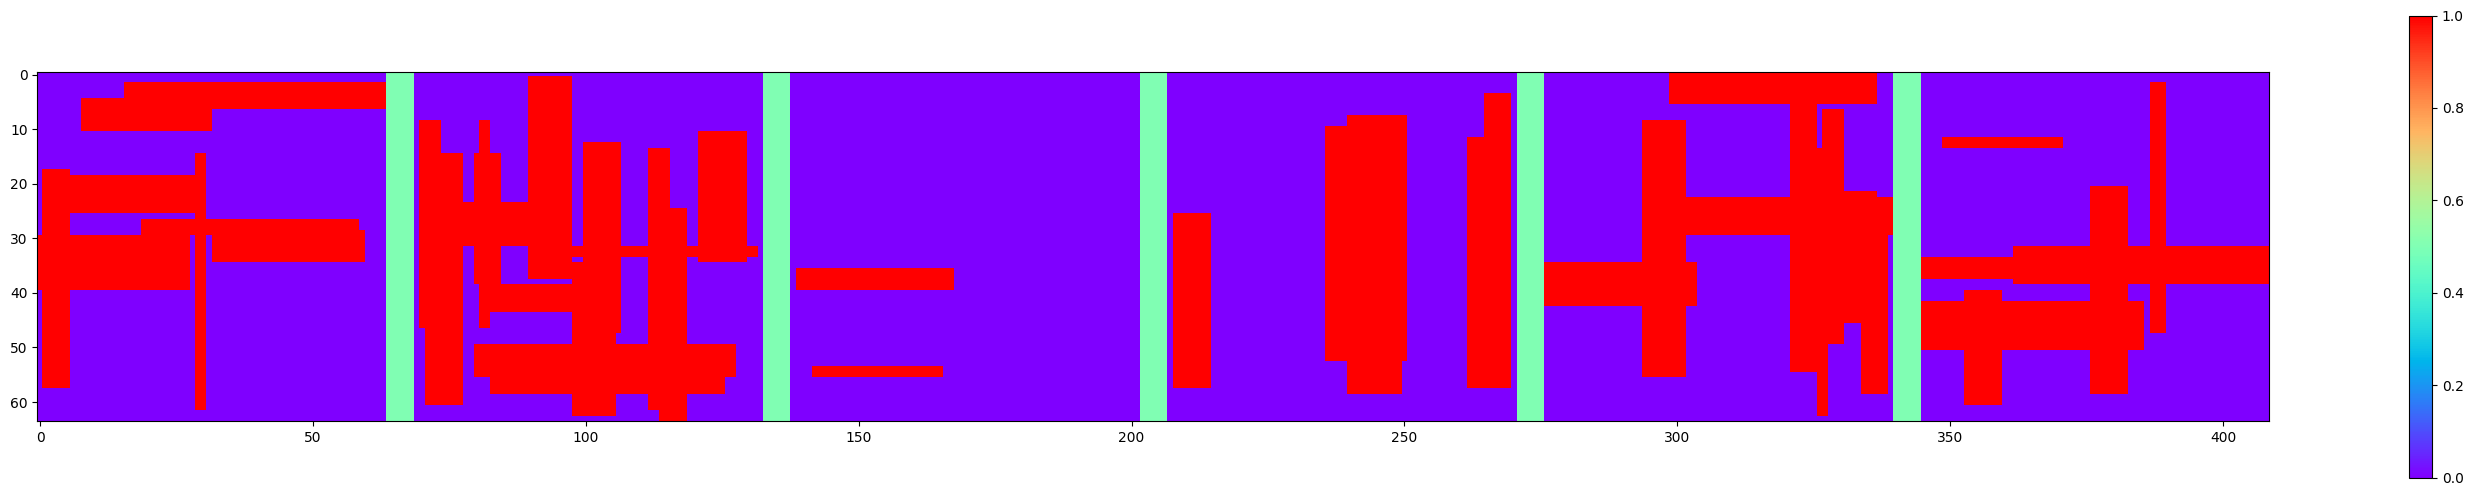

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

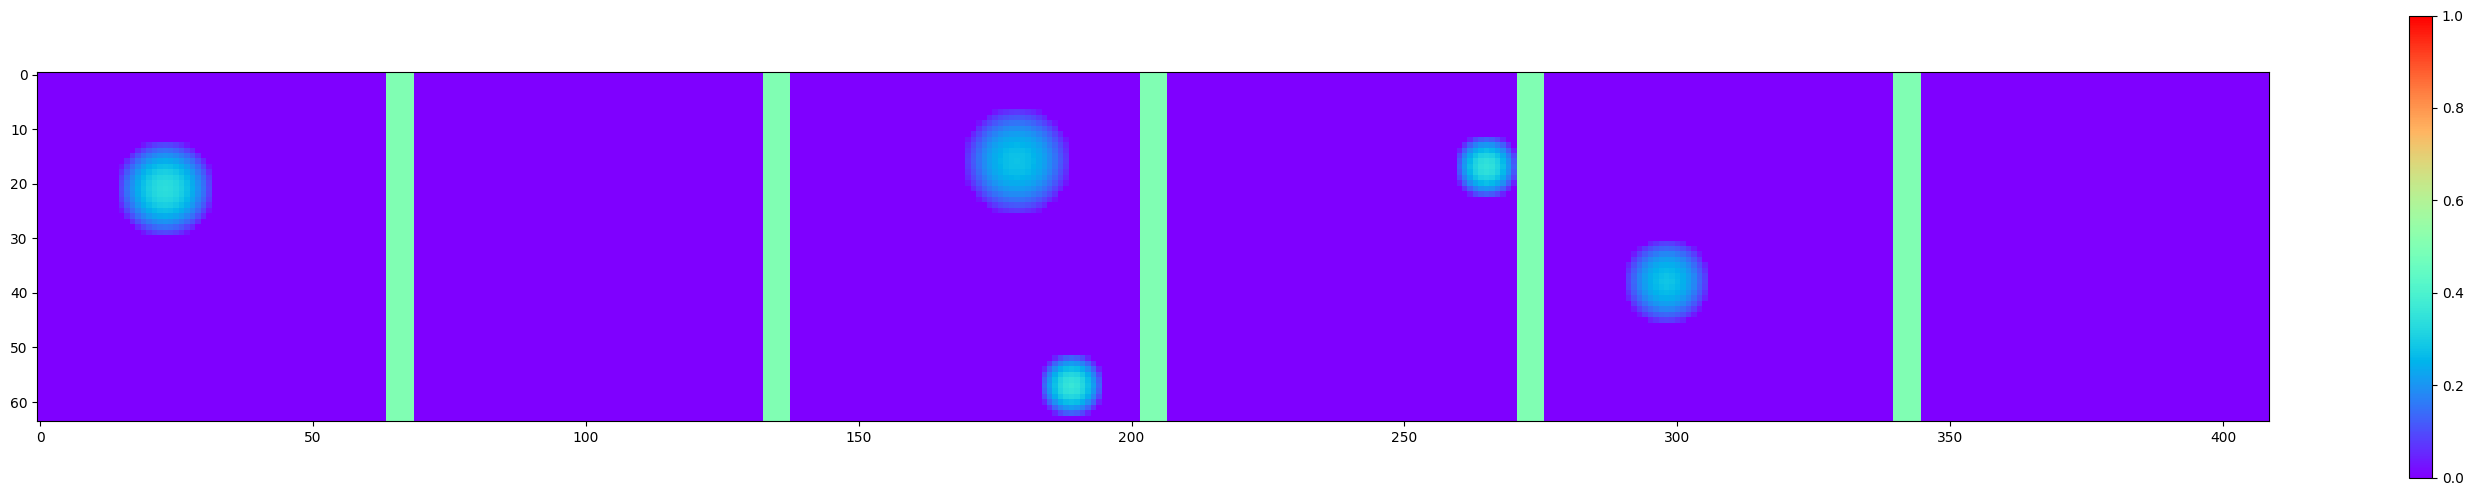

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

Supervision faible (ou apprentissage faiblement supervisé) fait référence à des situations où les données d'entraînement ne sont pas parfaitement annotées ou où les annotations sont incomplètes, imprécises ou bruitées. Contrairement à la supervision forte, où chaque exemple d'entraînement est accompagné d'une étiquette précise et détaillée, la supervision faible repose sur des informations partielles ou indirectes pour guider l'apprentissage.

Dans ce problème, la supervision faible s'applique car :

Les images générées par gen_dr contiennent à la fois des disques (considérés comme du bruit) et des rectangles (les objets d'intérêt).

La cible idéale (ideal_targets) est fournie, mais en pratique, elle n'est pas disponible. Cela signifie que l'on dispose d'une forme de supervision (les cibles idéales), mais elle est limitée ou inaccessible dans un scénario réel.

L'objectif est de segmenter les pixels affectés par les rectangles avant corruption, ce qui nécessite de distinguer les rectangles des disques (bruit) sans avoir accès à des annotations parfaites pour chaque pixel.

Ainsi, ce problème entre dans la catégorie de la supervision faible car il repose sur des informations partielles (les cibles idéales) pour entraîner un modèle à segmenter les rectangles dans un contexte où le bruit (disques) est présent.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

Le modèle identifie bien la forme générale des rectangles, mais les transitions restent floues, avec des bords imprécis et quelques faux positifs aux zones de recouvrement avec les disques. Malgré ces artefacts, le UNet parvient à apprendre la structure principale. Des améliorations pourraient inclure un ajustement de l’architecture ou une meilleure régularisation pour affiner les contours et réduire les confusions dans les zones bruitées.

Epoch [10/50], Loss: 0.6199
Epoch [20/50], Loss: 0.3597
Epoch [30/50], Loss: 0.2782
Epoch [40/50], Loss: 0.2713
Epoch [50/50], Loss: 0.3238


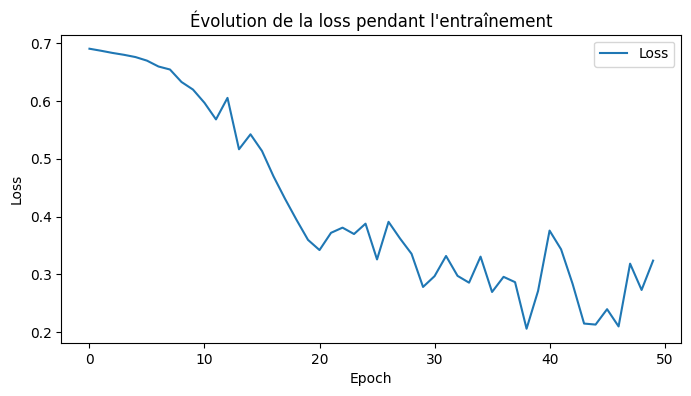

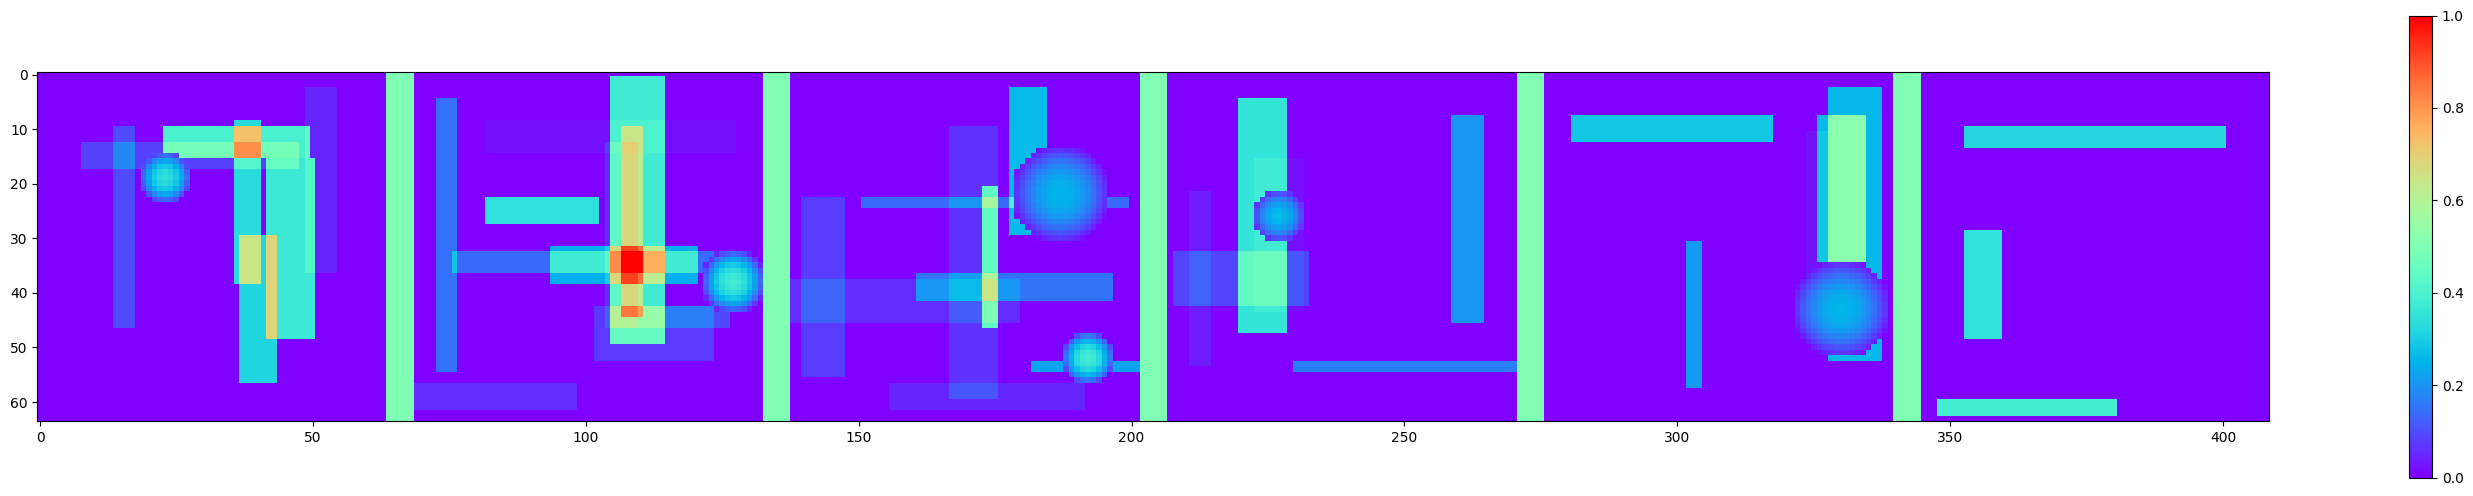

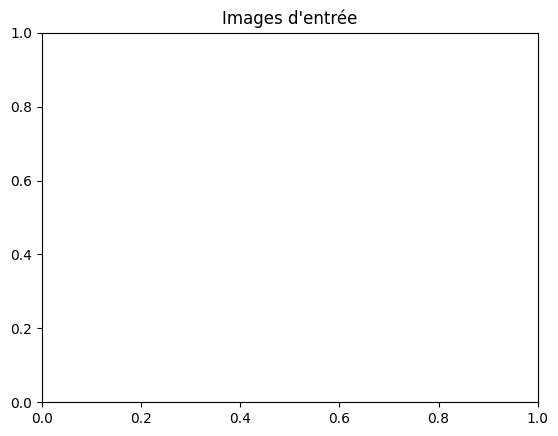

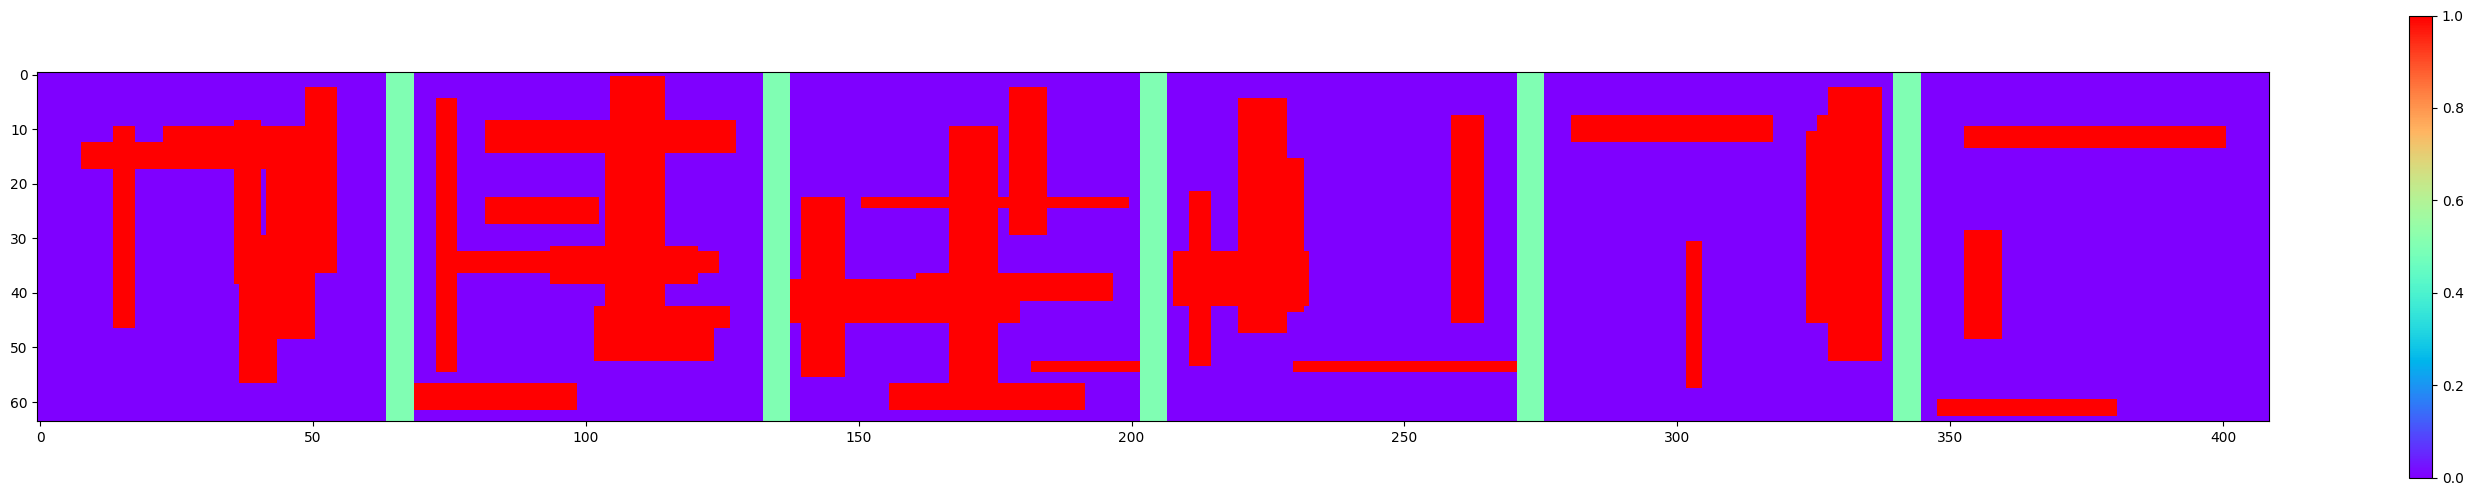

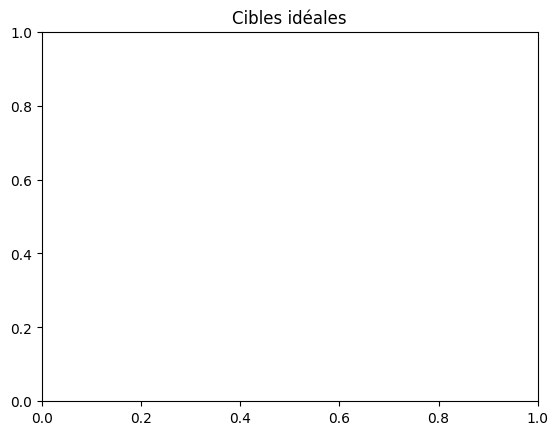

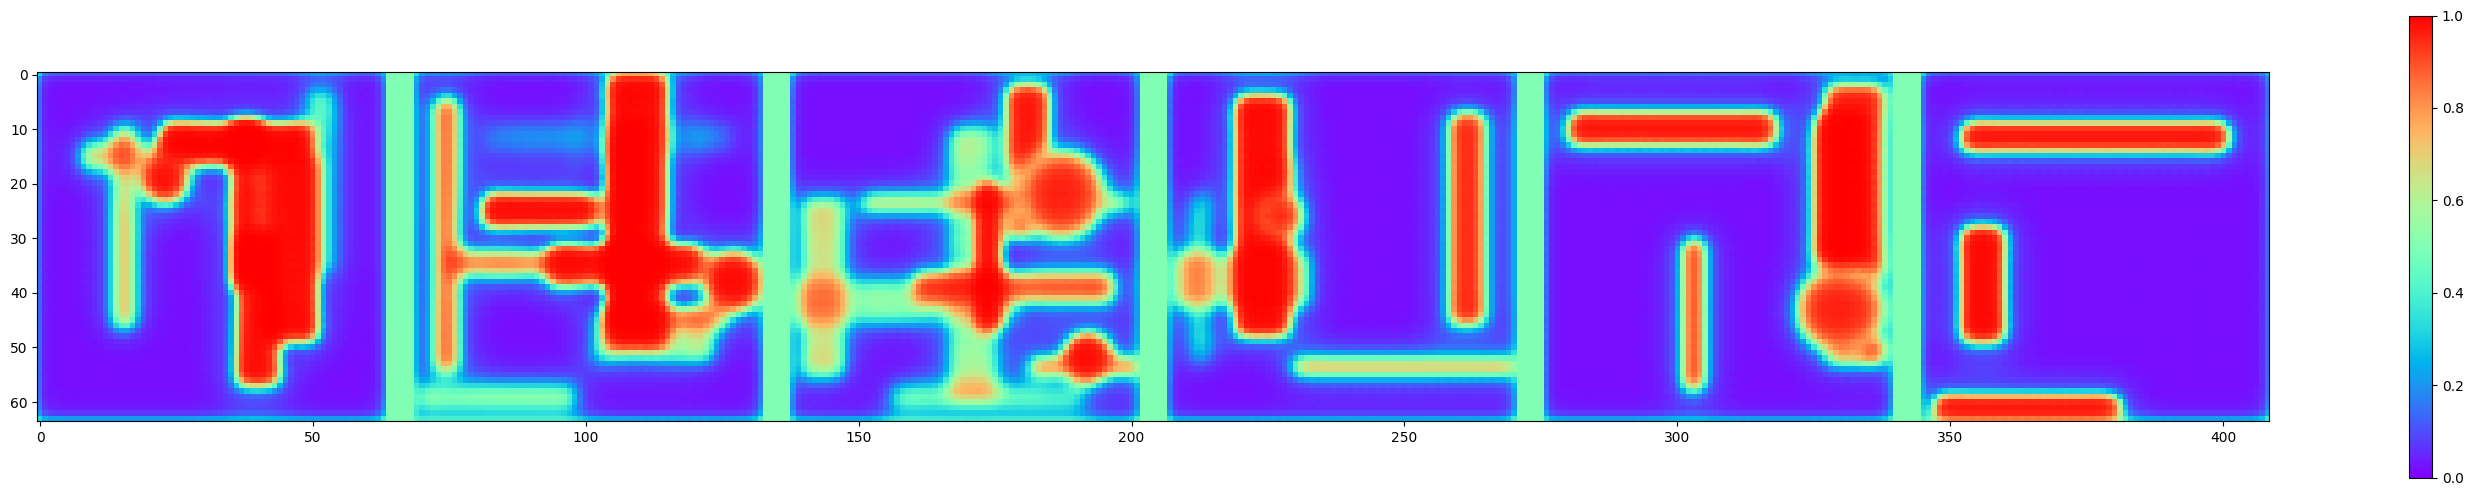

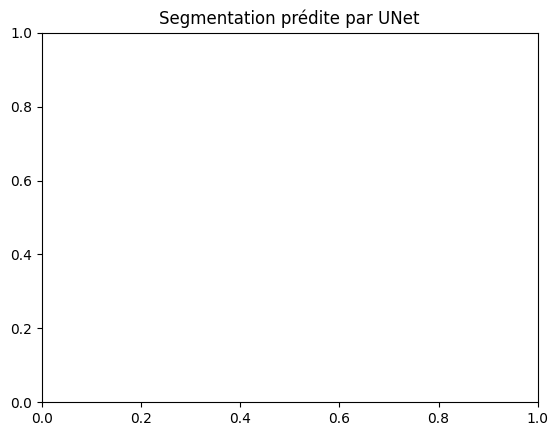

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- On suppose que les fonctions suivantes sont déjà définies dans votre environnement ---
# - gen_dr(n): qui renvoie un tuple (inputs, ideal_targets) sous forme de tenseurs PyTorch.
# - voir_batch2D(data, n, fig, k, min_scale, max_scale): qui permet d'afficher un batch d'images.
# --------------------------------------------------------------------------------------------

# Définition d'un UNet simplifié pour la segmentation binaire
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = self._block(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self._block(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self._block(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self._block(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self._block(features * 8, features * 16)

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._block(features * 16, features * 8)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block(features * 8, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block(features * 4, features * 2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features)

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

# Configuration de l'entraînement
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=1).to(device)
criterion = nn.BCELoss()  # Pour une segmentation binaire
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
batch_size = 6

loss_history = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    # Génération d'un batch de données
    inputs_tensor, targets_tensor = gen_dr(batch_size)

    # After: Remove unsqueeze(1) if inputs_tensor is already [batch, 1, H, W]
    inputs = inputs_tensor.float().to(device)
    targets = targets_tensor.float().to(device)


    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward et mise à jour des poids
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Affichage de l'évolution de la loss
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Évolution de la loss pendant l'entraînement")
plt.legend()
plt.show()

# --- Visualisation des résultats après entraînement ---

# Génération d'un nouveau batch pour l'évaluation
inputs_tensor, targets_tensor = gen_dr(batch_size)
inputs = inputs_tensor.float().to(device)

# Passage en mode évaluation pour la prédiction
with torch.no_grad():
    predictions = model(inputs).cpu()


# Visualisation des images d'entrée, de la cible idéale et des prédictions
fig_input = plt.figure(figsize=(36, 6))
voir_batch2D(inputs_tensor, batch_size, fig_input, k=0, min_scale=0, max_scale=1)
plt.title("Images d'entrée")

fig_target = plt.figure(figsize=(36, 6))
voir_batch2D(targets_tensor, batch_size, fig_target, k=0, min_scale=0, max_scale=1)
plt.title("Cibles idéales")

fig_pred = plt.figure(figsize=(36, 6))
voir_batch2D(predictions, batch_size, fig_pred, k=0, min_scale=0, max_scale=1)
plt.title("Segmentation prédite par UNet")
plt.show()


\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




tensor([1.7359, 2.8255, 5.6656, 2.4270, 5.4366, 4.0060])


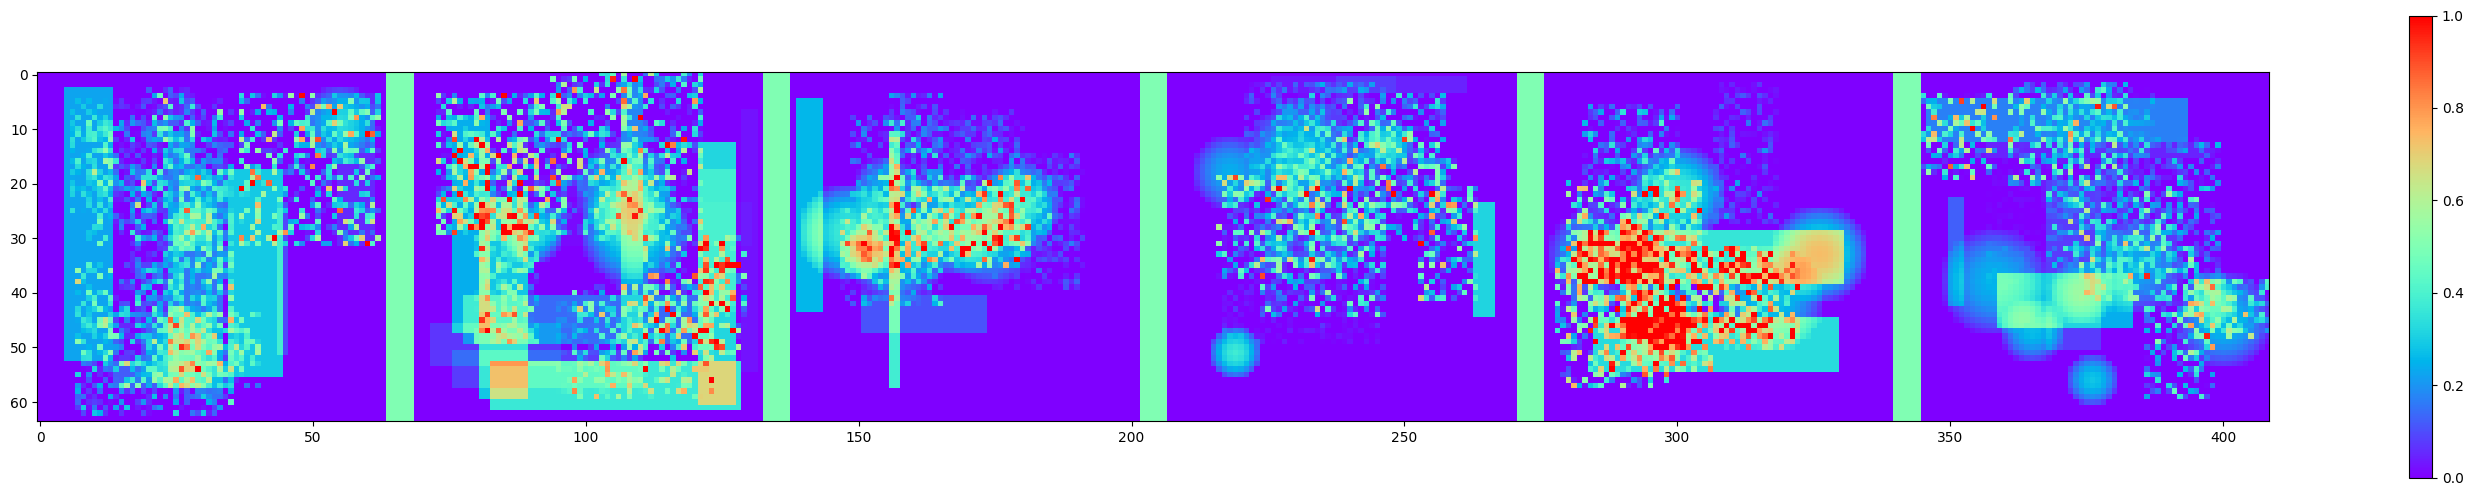

tensor([2.5754, 2.4170, 5.0124, 2.2814, 4.4939, 3.8186])


In [17]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

Q1 Définir un Loader à partir du Dataset précédent (2 workers)

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, n_samples):
        self.inputs, self.targets = gen_ex2(n_samples)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Création du dataset et du DataLoader
batch_size = 64
dataset = CustomDataset(n_samples=1000)  # Nombre d'échantillons arbitraire
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


tensor([ 4.0995,  9.5602,  3.4085,  4.2276,  3.7143,  4.2953,  6.7834,  3.3203,
         6.8842,  5.1141,  7.7800,  6.8441,  7.2021,  4.9197,  4.1908,  4.4721,
         4.6369,  2.5899,  6.1862,  2.6552,  4.9048,  6.0887,  3.9747,  1.5455,
         2.3906,  1.4173,  3.9313,  3.9090,  4.7875,  7.9211,  4.6169,  3.9519,
         1.9069,  5.2844,  4.8949,  4.4534,  5.1849,  1.6854,  4.8717,  2.3907,
         3.9491,  5.3937,  7.1652,  5.8673,  6.1253,  5.0915,  2.1849,  5.2504,
         3.3828,  6.5443,  4.0375,  3.4929,  2.7725,  1.9983,  1.7689,  6.7386,
        10.1622,  5.7434,  4.6986,  5.1784,  4.3684,  4.6191,  0.4886,  2.6322,
         7.9399,  5.4435,  5.0105,  4.8622,  7.6702,  3.8946,  2.9083,  4.5899,
         2.6895,  6.5747,  6.0834,  5.7460,  6.6845,  6.6571,  3.5538,  4.6224,
         5.0624,  4.3950,  6.7450,  4.9927,  4.4218,  3.1670,  6.5954,  5.6535,
         8.1659,  1.4110,  2.2862,  3.1406,  5.3471,  5.3366,  3.8698,  4.3676,
         6.0066,  4.6296,  1.4749,  2.56

**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

# Définition de la fonction de perte quantile pour tau = 0.5 (médiane)
def quantile_loss(y_pred, y_true, tau=0.5):
    error = y_true - y_pred
    return torch.mean(torch.max(tau * error, (tau - 1) * error))

# Charger ResNet18 pré-entraîné et modifier la dernière couche
class ResNet18Median(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=False)  # On ne charge pas les poids pré-entraînés
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)  # Une seule sortie pour la médiane

    def forward(self, x):
        return self.resnet(x).squeeze(1)  # Suppression de la dimension inutile

# Instancier le modèle
model = ResNet18Median()

# Définition de l'optimiseur et de la fonction de perte
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = lambda y_pred, y_true: quantile_loss(y_pred, y_true, tau=0.5)

num_epochs = 50  # Nombre d'époques
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        images = images.repeat(1, 3, 1, 1)  # Convertit [batch, 1, H, W] -> [batch, 3, H, W]

        predictions = model(images)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Époque {epoch+1}/{num_epochs}, Perte: {epoch_loss/len(loader)}")



Époque 1/50, Perte: 0.9837081022560596
Époque 2/50, Perte: 0.707053404301405
Époque 3/50, Perte: 0.6369120664894581
Époque 4/50, Perte: 0.5735396556556225
Époque 5/50, Perte: 0.51717340759933
Époque 6/50, Perte: 0.4574589692056179
Époque 7/50, Perte: 0.44141638837754726
Époque 8/50, Perte: 0.3648411240428686
Époque 9/50, Perte: 0.39266801439225674
Époque 10/50, Perte: 0.3645117059350014
Époque 11/50, Perte: 0.3707361798733473
Époque 12/50, Perte: 0.35671513341367245
Époque 13/50, Perte: 0.336518881842494
Époque 14/50, Perte: 0.30957625433802605
Époque 15/50, Perte: 0.30397582054138184
Époque 16/50, Perte: 0.2740965923294425
Époque 17/50, Perte: 0.2615493554621935
Époque 18/50, Perte: 0.2756367018446326
Époque 19/50, Perte: 0.2386483158916235
Époque 20/50, Perte: 0.22993650566786528
Époque 21/50, Perte: 0.2513703927397728
Époque 22/50, Perte: 0.22513121739029884
Époque 23/50, Perte: 0.2370329825207591
Époque 24/50, Perte: 0.24554495327174664
Époque 25/50, Perte: 0.2297208085656166
Époqu

L'absence d'une phase de validation dans cet entraînement peut être justifiée par plusieurs raisons :

**Données synthétiques générées dynamiquement**

La fonction gen_ex2(n) génère des données à la volée, ce qui signifie que chaque batch est différent mais suit la même distribution.
Par conséquent, les données de validation ne seraient pas fondamentalement différentes des données d'entraînement.
Si la distribution ne change pas, la validation ne donne pas d’information supplémentaire.


**Optimisation directe de la médiane conditionnelle**

On entraîne le modèle pour approximer la médiane conditionnelle.
Contrairement à une tâche de classification où un surajustement peut être détecté via la validation, ici la médiane est robuste et moins affectée par le bruit ou les outliers.
Si le modèle apprend bien sur les données d'entraînement, il généralisera naturellement sur des données similaires.

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

In [22]:
class ResNet18Quantiles(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=False)  # Modèle ResNet18 sans poids pré-entraînés
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 3)  # 3 sorties : Q1, Q2, Q3

    def forward(self, x):
        return self.resnet(x)  # On ne squeeze plus, car on a 3 sorties

def quantile_loss(y_pred, y_true, taus=[0.25, 0.5, 0.75]):
    """
    Fonction de coût quantile pour plusieurs tau.
    - y_pred : [batch, 3]  (Prédictions des Q1, Q2, Q3)
    - y_true : [batch, 1]  (Valeur cible réelle)
    - taus : Liste des quantiles à prédire (Q1, Q2, Q3)
    """
    losses = []
    for i, tau in enumerate(taus):
        error = y_true - y_pred[:, i]
        losses.append(torch.mean(torch.max(tau * error, (tau - 1) * error)))
    return sum(losses)  # Somme des pertes pour Q1, Q2, Q3



# Instancier le modèle
model = ResNet18Quantiles()

# Définition de l'optimiseur et de la fonction de perte
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = lambda y_pred, y_true: quantile_loss(y_pred, y_true, taus=[0.25, 0.5, 0.75])

num_epochs = 50  # Nombre d'époques
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        images = images.repeat(1, 3, 1, 1)  # Convertit [batch, 1, H, W] -> [batch, 3, H, W]

        predictions = model(images)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Époque {epoch+1}/{num_epochs}, Perte: {epoch_loss/len(loader)}")


Époque 1/50, Perte: 2.7062881737947464
Époque 2/50, Perte: 1.8425034508109093
Époque 3/50, Perte: 1.6591118946671486
Époque 4/50, Perte: 1.3302579820156097
Époque 5/50, Perte: 1.1445568539202213
Époque 6/50, Perte: 1.1036824733018875
Époque 7/50, Perte: 0.9606997258961201
Époque 8/50, Perte: 0.8818299062550068
Époque 9/50, Perte: 0.8592508248984814
Époque 10/50, Perte: 0.7613573148846626
Époque 11/50, Perte: 0.7064632587134838
Époque 12/50, Perte: 0.6613577213138342
Époque 13/50, Perte: 0.6852790638804436
Époque 14/50, Perte: 0.8748155385255814
Époque 15/50, Perte: 0.5874018128961325
Époque 16/50, Perte: 0.611910093575716
Époque 17/50, Perte: 0.7570660226047039
Époque 18/50, Perte: 0.6861024908721447
Époque 19/50, Perte: 0.6137156337499619
Époque 20/50, Perte: 0.5474534425884485
Époque 21/50, Perte: 0.494590699672699
Époque 22/50, Perte: 0.4857112932950258
Époque 23/50, Perte: 0.6223007291555405
Époque 24/50, Perte: 0.6201825570315123
Époque 25/50, Perte: 0.5826079454272985
Époque 26/5

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

In [ ]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

In [ ]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).